# Generates synthetic time series

References:

- Viggiano et al. 2020: Modelling Lagrangian velocity and acceleration in turbulent flows as infinitely differentiable stochastic processes
- Sawford 1991: 


In [1]:
import numpy as np
#from scipy.linalg import cholesky, toeplitz
import scipy.fft as fft

from sstats import sigp
from sstats import tseries


%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
T = 1000
dt = 1/24

N = int(T/dt)
time = np.arange(0,T,dt)
assert N==time.size

w = np.random.randn(N)
w_hat = fft.fft(w)
omega = fft.fftfreq(w.size, d=dt)
domega = omega[1]

print(f"rms(w) = {np.std(w)}")

rms(w) = 0.9940462823102424


### Verifying w spectral distribution

The squared amplitude of w averages to $N$ (number of samples)

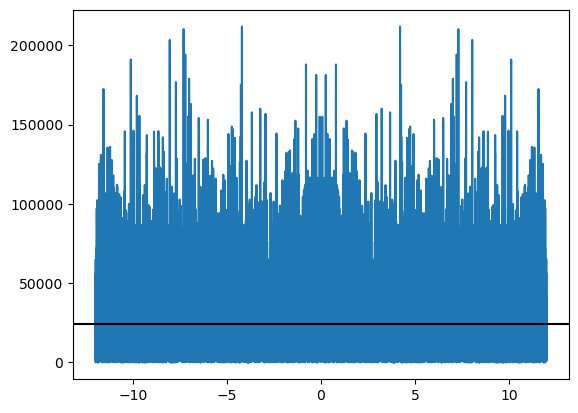

In [3]:
fig, ax = plt.subplots(1,1)
ax.plot(fft.fftshift(omega), fft.fftshift(abs(w_hat))**2)
ax.axhline(N, color="k")

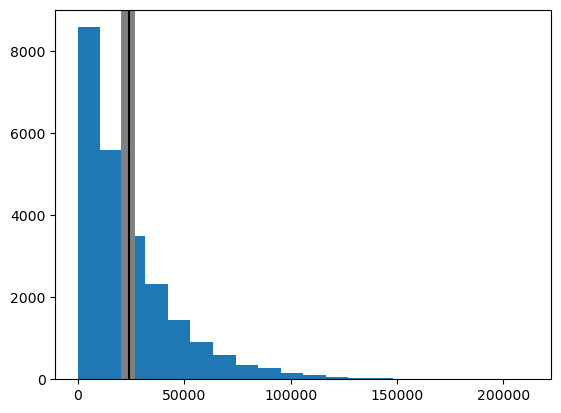

In [4]:
fig, ax = plt.subplots(1,1)
ax.hist(abs(w_hat)**2, bins=20)
ax.axvline(np.mean(abs(w_hat)**2), color="0.5", lw=10)
ax.axvline(N, color="k")

In [5]:
tau_eta = 1
T = 10

n_layers = 10

rad = 2*np.pi
#rad = 1

u_hat = w_hat /(1-1j*rad*omega*T) /(1-1j*rad*omega*tau_eta)**(n_layers-1)

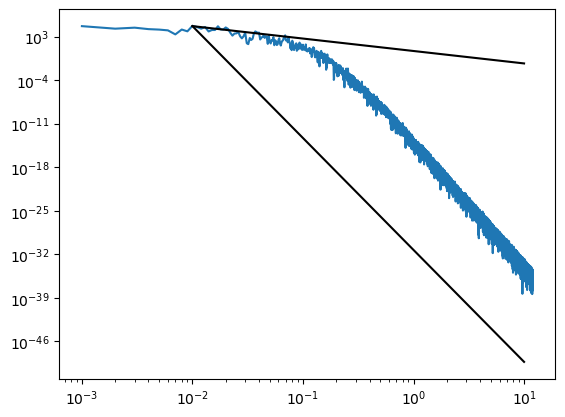

In [6]:
i = np.where(omega>0)

fig, ax = plt.subplots(1,1)
ax.loglog(omega[i], abs(u_hat[i])**2)

x_ref = np.array([1e-2, 10])
y_ref = 5*1e4
#ax.plot(x_ref, y_ref/(x_ref/x_ref[0])**1, "k")
ax.plot(x_ref, y_ref/(x_ref/x_ref[0])**2, "k")
#ax.plot(x_ref, y_ref/(x_ref/x_ref[0])**3, "k")
ax.plot(x_ref, y_ref/(x_ref/x_ref[0])**(2*n_layers-2), "k")
#ax.axhline(N, color="k")

In [7]:
u = fft.ifft(u_hat)
print(f"std(u) = {u.std()}")

# fix std
u = u/u.std()

std(u) = 0.04298014510159523


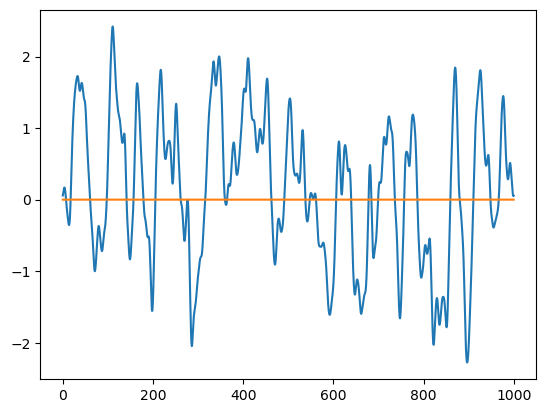

In [8]:
fig, ax = plt.subplots(1,1)
ax.plot(time, np.real(u))
ax.plot(time, np.imag(u))
#ax.set_xlim(0,200)

In [9]:
corr, lag = sigp.correlate_np(u, u)
lag = lag*dt

/Users/aponte/.miniconda3/envs/sstats/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(0.0, 50.0)

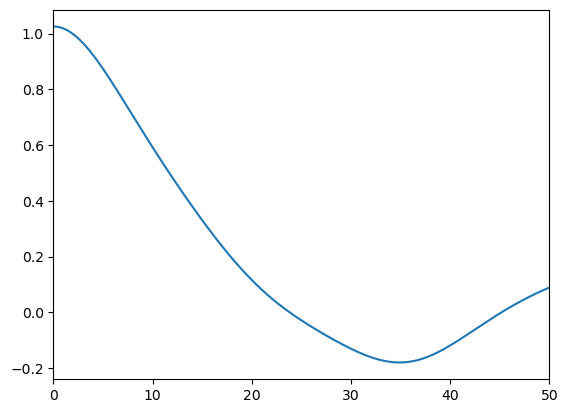

In [10]:
fig, ax = plt.subplots(1,1)
ax.plot(lag, corr)
ax.set_xlim(0,50)

In [11]:
wrapper = tseries.wrapper

from scipy.fft import fft, ifft, fftfreq

def _spectral_viggiano(T, tau_eta, time, *args, e=None, dt=None, n_layers=None, seed=None, **kwargs):
    """exp_autocorr core code. See general_spectral doc"""
    # prepare fourier decomposition
    #t = time.squeeze()    
    #scale = rms / np.sqrt(c(0))
    #
    rng = np.random.default_rng(seed=seed)
    if not isinstance(time, int):
        time = time.size
    extra = (time,) + tuple(a.size for a in args)
    extra_ones = (extra[0],) + tuple(1 for e in extra[1:])
    out = np.zeros((T.size, tau_eta.size) + extra)
    #assert False, extra
    omega = 2*np.pi*fftfreq(time, d=dt).reshape(extra_ones)
    for i, _T in enumerate(T.flatten()):
        for j, _tau_eta in enumerate(tau_eta.flatten()):
            w = rng.normal(0.0, 1.0, extra)
            u_hat = fft(w, axis=0) /(1-1j*omega*_T) /(1-1j*omega*_tau_eta)**(n_layers-1)
            out[i,j, ...] = ifft(u_hat, axis=0).real
    return out


def spectral_viggiano(time, T, tau_eta, n_layers, draws=1, dummy_dims=None, **kwargs):
    """Generate a time series that will verify the autocorrelation (2.14)-(2.18) in Viggiano et al. 2020
    Modelling Lagrangian velocity and acceleration in turbulent flows as infinitely differentiable stochastic processes
    J. Fluid Mech.
    
    Parameters:
    -----------
    time: int, np.ndarray, tuple
        Number of time steps, time array, tuple (T, dt)
    T: float, iterable
        Long decorrelation timescale
    tau_eta: float, iterable
        Short decorrelation timescale
    n_layers: float, iterable
        Number of layers
    draws: int, optional
        Size of the ensemble, default to 1
    seed: int, optional
        numpy seed
    """
    _dummy_dims = dict(draw=draws)
    if dummy_dims is not None:
        _dummy_dims.update(**dummy_dims)

    if isinstance(time, tuple):
        dt = time[1]
    else:
        dt = time[1] - time[0]

    x = wrapper(
        _spectral_viggiano,
        time,
        params={
            "T": T,
            "tau_eta": tau_eta,
        },
        dummy_dims=_dummy_dims,
        dt=dt,
        n_layers=n_layers,
        **kwargs,
    )
    if "T" not in x.dims:
        x = x.assign_attrs(T=T)
    if "tau_eta" not in x.dims:
        x = x.assign_attrs(tau_eta=tau_eta)

    return x

x = spectral_viggiano((1000,1/24), [5,10,20,40], [1,2], 10, draws=10).compute()

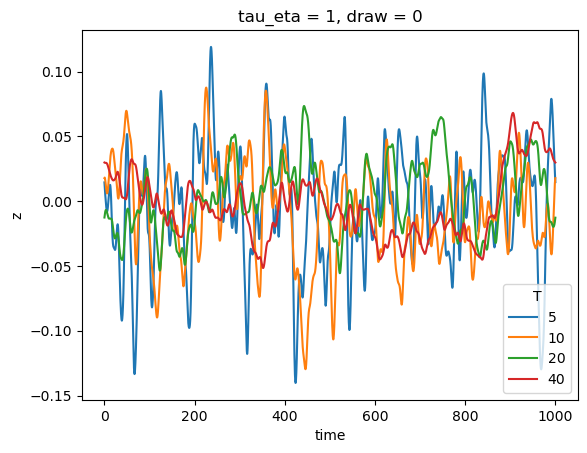

In [12]:
x.isel(draw=0, tau_eta=0).plot(hue="T")

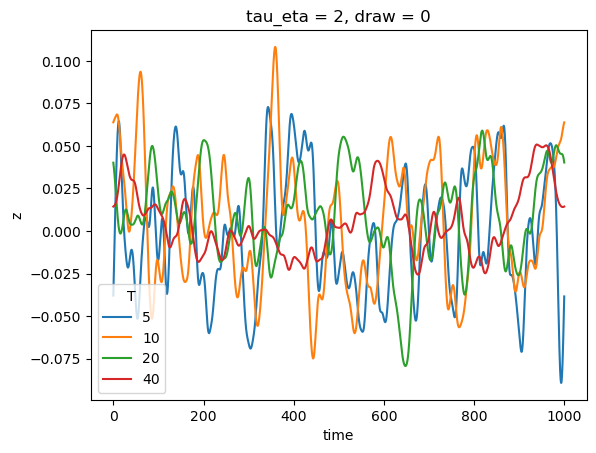

In [13]:
x.isel(draw=0, tau_eta=1).plot(hue="T")